In [7]:
from natsort import natsorted
import os
from tqdm import tqdm
import soundfile as sf
import librosa
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from utils import *
import pandas as pd
from torchaudio.models import Emformer
import torch.nn as nn 
import torch.optim as optim

In [14]:
df = {'model': [], 'val loss': []}
for i in list(filter(lambda i: "Emformer" in i, get_files('/data/pitch_estimation'))):
    result = load_pkl(os.path.join(i, 'stats.pkl'))
    df['model'].append(os.path.basename(i))
    df['val loss'].append(min(result['val_loss']))
df = pd.DataFrame(df).sort_values('val loss')
df['model'] = df['model'].apply(lambda x: x.replace('Emformer', '').replace('_', ' '))
df['val loss'] = df['val loss'].apply(lambda x: round(x, 3))
df.to_csv('emformer_result.csv', index=False)

In [3]:
B, C, T = 1, 2, 5
C_encoded = 2
data = torch.ones((B, C, T))
prior_info = torch.zeros((B, C_encoded))

result = torch.concatenate((data, prior_info.unsqueeze(-1).expand(-1, -1, T)), dim = 1)
print(result.shape)
result

torch.Size([1, 4, 5])


tensor([[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])

In [12]:
# TODO: copy this block for MIR 1k dataset and dataloader. 
# Create a pytorch dataset for MIR 1k.


CENTS_PER_BIN = 20  # cents
MAX_FMAX = 2006.  # hz
PITCH_BINS = 360
SAMPLE_RATE = 16000  # hz
WINDOW_SIZE = 1024

def frequency_to_cents(frequency):
    """Convert frequency in Hz to cents"""
    return 1200 * torch.log2(frequency / 10.)

# We can use this function to quantize the pitch to the nearest bin.
# but 1997 actually corresponds to 31.7hz instead of 32.7 as noted in the paper. 
def cents_to_bins(cents, quantize_fn=torch.floor):
    """Converts cents to pitch bins"""
    bins = (cents - 1997.3794084376191) / CENTS_PER_BIN
    return quantize_fn(bins).int()

def frequency_to_bins(frequency, quantize_fn=torch.floor):
    """Convert frequency in Hz to pitch bins"""
    mask = torch.isclose(frequency, torch.tensor([0.0], dtype = torch.float32))
    result = cents_to_bins(frequency_to_cents(frequency), quantize_fn)
    
    # Pitch label: 0 - 359 
    # 360: unvoiced.
    # Total of 361 bins.
    result[mask] = 360
    return result 


class MIR1kDataset(Dataset):
    def __init__(self, mel_dir, pitch_dir, fids):
        self.mel_dir = mel_dir
        self.pitch_dir = pitch_dir
        
        # File ids.
        fids = read(fids).strip().split('\n')
        
        # Check if all features files exist. 
        self.fids = fids
        for i in fids:
            assert os.path.exists(os.path.join(mel_dir, f"{i}.npy"))
            assert os.path.exists(os.path.join(pitch_dir, f"{i}.npy"))
    def __len__(self):
        return len(self.fids)

    def __getitem__(self, idx):
        fid = self.fids[idx]
        mel = np.load(os.path.join(self.mel_dir, f"{fid}.npy"))
        pitch = np.load(os.path.join(self.pitch_dir, f"{fid}.npy"))
        return mel, pitch

# Create a collate fn that randomly crop the waveform and pitch.
# min_len: 1 sec of mel. max_len: 3sec of mel.
def collate_fn(batch, min_len = 50, max_len = 150):
    mel = [i[0] for i in batch]
    pitch = [i[1] for i in batch]
    
    # Randomly crop the mel and pitch.
    crop_len = random.randint(min_len, max_len)
    min_mel_len = min([i.shape[1] for i in mel])
    
    random_start = random.randint(0, min_mel_len - crop_len)
    
    # (B, C, crop_len)
    mel = torch.stack([torch.tensor(i[:, random_start:random_start + crop_len]) for i in mel]).float()
    
    # (B, crop_len)
    pitch = torch.stack([torch.tensor(i[random_start:random_start + crop_len]) for i in pitch]).float()
    # orig_pitch = pitch.clone()
    
    # Convert pitch to cents.
    pitch = frequency_to_bins(pitch)
    return mel, pitch

def eval_collate_fn(batch):
    mel = [i[0] for i in batch]
    pitch = [i[1] for i in batch]
    
    # Pad the mel and pitch.
    length = torch.tensor([i.shape[1] for i in mel]).long()
    max_len = max([i.shape[1] for i in mel])
    mel = torch.stack([torch.concatenate((torch.tensor(i), torch.zeros((i.shape[0], max_len - i.shape[1]))), dim = 1) for i in mel]).float()
    pitch = torch.stack([torch.concatenate((torch.tensor(i), torch.zeros(max_len - i.shape[0]))) for i in pitch]).float()
    assert mel.shape[-1] == pitch.shape[-1]
    
    pitch = frequency_to_bins(pitch).long()
    return mel, pitch, length
# Train dataset and dataloader.
train_dataset = MIR1kDataset(mel_dir='/data/pitch_estimation/dataset/MIR-1K/mel_spec_both', 
                             pitch_dir='/data/pitch_estimation/dataset/MIR-1K/pitch_50', 
                             fids='/data/pitch_estimation/dataset/MIR-1K/train.txt')
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn=eval_collate_fn)


# Val dataset and dataloader.
val_dataset = MIR1kDataset(mel_dir='/data/pitch_estimation/dataset/MIR-1K/mel_spec_both',
                           pitch_dir='/data/pitch_estimation/dataset/MIR-1K/pitch_50',
                           fids='/data/pitch_estimation/dataset/MIR-1K/val.txt')
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=eval_collate_fn)


# Test dataset and dataloader.
test_dataset = MIR1kDataset(mel_dir='/data/pitch_estimation/dataset/MIR-1K/mel_spec_both',
                            pitch_dir='/data/pitch_estimation/dataset/MIR-1K/pitch_50',
                            fids='/data/pitch_estimation/dataset/MIR-1K/test.txt')
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=eval_collate_fn)


In [13]:
for i in test_dataset:
    print(i[0].shape, i[1].shape)
    break

(256, 305) (305,)


In [14]:
def test_model(model, dataset, gpu_number = 0):
    device = torch.device('cuda:{}'.format(gpu_number))
    model.eval()
    total_loss = 0
    num_left = model.emformer.left_context_length
    num_right = model.emformer.right_context_length
    
    
    with torch.no_grad():
        for mel, pitch in tqdm(dataset, total = len(dataset)):
            
            # (1, C, T)
            mel = torch.tensor(mel).unsqueeze(0).float().to(device)
            pitch = torch.tensor(pitch).unsqueeze(0).long().to(device)
            
            # length = segment length + right context length.
            
    return total_loss / len(dataset)

In [15]:
train_dataset[0][0].shape

(256, 319)

In [16]:
def train_model(model, train_loader, val_loader, num_epochs, num_eval_epoch, 
                criterion=None, optimizer=None, scheduler=None, save_dir = "", gpu_number = 6):
    # If no criterion is provided, use cross-entropy loss
    mkdir(save_dir)
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    
    device = torch.device(f'cuda:{gpu_number}' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Move the model to the appropriate device
    model.to(device)
    
    # If no optimizer is provided, use Adam
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    
    train_loss = []
    val_loss = []
    val_acc =[]
    
    # Loop over the dataset multiple times
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Iterate over data.
        for index, (inputs, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
            inputs, labels = inputs.to(device), labels.to(device).long()
            length = torch.tensor([i.shape[-1] for i in inputs]).long() - model.right_context_length
            length = length.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            # Emformer needs BTC. 
            outputs, length = model(inputs.transpose(1, -1), length)
            
            # Only calculate on the valid outputs.
            # print(outputs.shape, labels.shape)
            loss = criterion(outputs.transpose(1, -1), labels[:, :outputs.shape[1]])
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        train_loss_epoch = running_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss_epoch}')
        train_loss.append(train_loss_epoch)
        
        # Step the scheduler if provided
        if scheduler is not None:
            scheduler.step()
        
        # Evaluate the model every num_eval_epoch epochs
        if (epoch + 1) % num_eval_epoch == 0:
            result = evaluate_model(model, val_loader, criterion, device)
            print(f'Epoch: {epoch} Validation Loss: {result["val_loss"]}, Validation Accuracy: {result["val_acc"]}')
            val_loss.append(result["val_loss"])
            val_acc.append(result["val_acc"])
            
            if result["val_loss"] < best_val_loss:
                best_val_loss = result["val_loss"]
                torch.save({'model_ckpt': model.state_dict(),
                            "optimizer": optimizer.state_dict(),
                            "epoch": epoch,
                            "best_val_loss": best_val_loss,
                            }, os.path.join(save_dir, 'best_val_ckpt.pth'))
                print(f"Best model saved at epoch {epoch}, val loss: {best_val_loss}")
    stats = {'train_loss': train_loss, 'val_loss': val_loss, 'val_acc': val_acc}
    save_pkl(stats, os.path.join(save_dir, 'stats.pkl'))

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        val_loss = 0.0
        count = 0
        for _, (inputs, labels, length) in tqdm(enumerate(dataloader), total = len(dataloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            length = length.to(device)
            outputs, length = model(inputs.transpose(1, -1), length - model.right_context_length)
            for i in range(len(length)):
                
                # (B, C, T)
                curr_output = outputs[i, :length[i]].transpose(0, 1).unsqueeze(0)
                
                #(B, T)
                curr_label = labels[i, :length[i]].unsqueeze(0)


                val_loss += criterion(curr_output, curr_label).item()
                count += 1
            # _, predicted = torch.max(outputs.data, 1)
            # total += labels.size(0)
            # correct += (predicted == labels).sum().item()
    
    # accuracy = 100 * correct / total
    val_loss /= count
    return {'val_loss': val_loss, 'val_acc': None}

In [17]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [28]:
class Emformer_Classifier(nn.Module):
    def __init__(self, input_dim = 80, num_heads = 4, ffn_dim = 512, num_layers = 9, segment_length = 8, 
                    right_context_length=2, left_context_length=2, num_classes = 361, activation='relu'):
        super(Emformer_Classifier, self).__init__()
        self.emformer = Emformer(input_dim=input_dim, num_heads=num_heads, ffn_dim=ffn_dim, num_layers=num_layers, 
                                segment_length=segment_length, right_context_length=right_context_length, 
                                left_context_length=left_context_length, activation=activation)
        
        self.linear = nn.Linear(input_dim, num_classes)
        self.right_context_length = self.emformer.right_context_length
    def forward(self, x, length):
        outputs, length = self.emformer(x, length)
        outputs = self.linear(outputs)
        return outputs, length

def plot_loss(directory):
    result = load_pkl(os.path.join(directory, "stats.pkl"))
    plt.plot(result['train_loss'], label='train_loss')
    plt.plot(result['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

Number of parameters: 7995497
Using device: cuda:5


  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:01<00:00, 10.32it/s]


Epoch 1/80, Loss: 3.818130782672337


100%|██████████| 13/13 [00:00<00:00, 37.40it/s]


Epoch: 0 Validation Loss: 2.8291804027557372, Validation Accuracy: None
Best model saved at epoch 0, val loss: 2.8291804027557372


100%|██████████| 14/14 [00:01<00:00,  9.87it/s]


Epoch 2/80, Loss: 2.740117243358067


100%|██████████| 13/13 [00:00<00:00, 37.38it/s]


Epoch: 1 Validation Loss: 2.370875632762909, Validation Accuracy: None
Best model saved at epoch 1, val loss: 2.370875632762909


100%|██████████| 14/14 [00:01<00:00, 10.52it/s]


Epoch 3/80, Loss: 2.198601245880127


100%|██████████| 13/13 [00:00<00:00, 37.58it/s]


Epoch: 2 Validation Loss: 1.7741978240013123, Validation Accuracy: None
Best model saved at epoch 2, val loss: 1.7741978240013123


100%|██████████| 14/14 [00:01<00:00,  9.63it/s]


Epoch 4/80, Loss: 1.8139247383390154


100%|██████████| 13/13 [00:00<00:00, 37.57it/s]


Epoch: 3 Validation Loss: 1.5046200859546661, Validation Accuracy: None
Best model saved at epoch 3, val loss: 1.5046200859546661


100%|██████████| 14/14 [00:01<00:00, 10.07it/s]


Epoch 5/80, Loss: 1.5499511105673653


100%|██████████| 13/13 [00:00<00:00, 37.94it/s]


Epoch: 4 Validation Loss: 1.4247058147192002, Validation Accuracy: None
Best model saved at epoch 4, val loss: 1.4247058147192002


100%|██████████| 14/14 [00:01<00:00, 10.17it/s]


Epoch 6/80, Loss: 1.4478502869606018


100%|██████████| 13/13 [00:00<00:00, 37.98it/s]


Epoch: 5 Validation Loss: 1.3357442337274552, Validation Accuracy: None
Best model saved at epoch 5, val loss: 1.3357442337274552


100%|██████████| 14/14 [00:01<00:00, 10.89it/s]


Epoch 7/80, Loss: 1.358316114970616


100%|██████████| 13/13 [00:00<00:00, 37.67it/s]


Epoch: 6 Validation Loss: 1.298894156217575, Validation Accuracy: None
Best model saved at epoch 6, val loss: 1.298894156217575


100%|██████████| 14/14 [00:01<00:00,  9.23it/s]


Epoch 8/80, Loss: 1.301453479698726


100%|██████████| 13/13 [00:00<00:00, 37.76it/s]


Epoch: 7 Validation Loss: 1.2153718209266662, Validation Accuracy: None
Best model saved at epoch 7, val loss: 1.2153718209266662


100%|██████████| 14/14 [00:01<00:00,  9.70it/s]


Epoch 9/80, Loss: 1.2409443940435136


100%|██████████| 13/13 [00:00<00:00, 37.59it/s]


Epoch: 8 Validation Loss: 1.1948493123054504, Validation Accuracy: None
Best model saved at epoch 8, val loss: 1.1948493123054504


100%|██████████| 14/14 [00:01<00:00, 10.08it/s]


Epoch 10/80, Loss: 1.1834317786352975


100%|██████████| 13/13 [00:00<00:00, 36.85it/s]


Epoch: 9 Validation Loss: 1.2254607915878295, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.58it/s]


Epoch 11/80, Loss: 1.1662325688770838


100%|██████████| 13/13 [00:00<00:00, 33.57it/s]


Epoch: 10 Validation Loss: 1.2109710216522216, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.23it/s]


Epoch 12/80, Loss: 1.1760606510298592


100%|██████████| 13/13 [00:00<00:00, 37.23it/s]


Epoch: 11 Validation Loss: 1.2032573413848877, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  8.97it/s]


Epoch 13/80, Loss: 1.093091334615435


100%|██████████| 13/13 [00:00<00:00, 37.42it/s]


Epoch: 12 Validation Loss: 1.120511039495468, Validation Accuracy: None
Best model saved at epoch 12, val loss: 1.120511039495468


100%|██████████| 14/14 [00:01<00:00,  9.72it/s]


Epoch 14/80, Loss: 1.0563459949834006


100%|██████████| 13/13 [00:00<00:00, 37.47it/s]


Epoch: 13 Validation Loss: 1.1017663818597794, Validation Accuracy: None
Best model saved at epoch 13, val loss: 1.1017663818597794


100%|██████████| 14/14 [00:01<00:00,  8.81it/s]


Epoch 15/80, Loss: 1.039431367601667


100%|██████████| 13/13 [00:00<00:00, 37.32it/s]


Epoch: 14 Validation Loss: 1.1352695500850678, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.29it/s]


Epoch 16/80, Loss: 1.0485756184373582


100%|██████████| 13/13 [00:00<00:00, 37.22it/s]


Epoch: 15 Validation Loss: 1.14055821955204, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.08it/s]


Epoch 17/80, Loss: 1.0198970564774104


100%|██████████| 13/13 [00:00<00:00, 37.38it/s]


Epoch: 16 Validation Loss: 1.1163546860218048, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.31it/s]


Epoch 18/80, Loss: 1.0443390820707594


100%|██████████| 13/13 [00:00<00:00, 37.49it/s]


Epoch: 17 Validation Loss: 1.1371188074350358, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.11it/s]


Epoch 19/80, Loss: 0.9564701957362038


100%|██████████| 13/13 [00:00<00:00, 37.43it/s]


Epoch: 18 Validation Loss: 1.0240605753660201, Validation Accuracy: None
Best model saved at epoch 18, val loss: 1.0240605753660201


100%|██████████| 14/14 [00:01<00:00,  9.24it/s]


Epoch 20/80, Loss: 0.9124897037233625


100%|██████████| 13/13 [00:00<00:00, 37.30it/s]


Epoch: 19 Validation Loss: 1.0494427478313446, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.74it/s]


Epoch 21/80, Loss: 0.899376277412687


100%|██████████| 13/13 [00:00<00:00, 37.36it/s]


Epoch: 20 Validation Loss: 1.0824884217977524, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.71it/s]


Epoch 22/80, Loss: 0.9041760734149388


100%|██████████| 13/13 [00:00<00:00, 37.19it/s]


Epoch: 21 Validation Loss: 1.0565684998035432, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.96it/s]


Epoch 23/80, Loss: 0.874578982591629


100%|██████████| 13/13 [00:00<00:00, 37.15it/s]


Epoch: 22 Validation Loss: 1.0071433693170548, Validation Accuracy: None
Best model saved at epoch 22, val loss: 1.0071433693170548


100%|██████████| 14/14 [00:01<00:00,  9.67it/s]


Epoch 24/80, Loss: 0.8603586256504059


100%|██████████| 13/13 [00:00<00:00, 37.27it/s]


Epoch: 23 Validation Loss: 1.0862749737501145, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.13it/s]


Epoch 25/80, Loss: 0.8482669932501656


100%|██████████| 13/13 [00:00<00:00, 37.36it/s]


Epoch: 24 Validation Loss: 1.0357017302513123, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.07it/s]


Epoch 26/80, Loss: 0.8125332168170384


100%|██████████| 13/13 [00:00<00:00, 37.35it/s]


Epoch: 25 Validation Loss: 0.9960272365808487, Validation Accuracy: None
Best model saved at epoch 25, val loss: 0.9960272365808487


100%|██████████| 14/14 [00:01<00:00,  8.98it/s]


Epoch 27/80, Loss: 0.7825017784323011


100%|██████████| 13/13 [00:00<00:00, 37.31it/s]


Epoch: 26 Validation Loss: 1.0150674962997437, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.08it/s]


Epoch 28/80, Loss: 0.8001432248524257


100%|██████████| 13/13 [00:00<00:00, 37.24it/s]


Epoch: 27 Validation Loss: 0.9948083609342575, Validation Accuracy: None
Best model saved at epoch 27, val loss: 0.9948083609342575


100%|██████████| 14/14 [00:01<00:00,  9.62it/s]


Epoch 29/80, Loss: 0.7814756163528987


100%|██████████| 13/13 [00:00<00:00, 37.26it/s]


Epoch: 28 Validation Loss: 1.01602209597826, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.49it/s]


Epoch 30/80, Loss: 0.8032585552760533


100%|██████████| 13/13 [00:00<00:00, 37.21it/s]


Epoch: 29 Validation Loss: 1.050977185368538, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.90it/s]


Epoch 31/80, Loss: 0.777690087045942


100%|██████████| 13/13 [00:00<00:00, 37.17it/s]


Epoch: 30 Validation Loss: 1.0298986250162125, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.57it/s]


Epoch 32/80, Loss: 0.7918066212109157


100%|██████████| 13/13 [00:00<00:00, 37.93it/s]


Epoch: 31 Validation Loss: 1.0299806821346282, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.97it/s]


Epoch 33/80, Loss: 0.836258066552026


100%|██████████| 13/13 [00:00<00:00, 37.94it/s]


Epoch: 32 Validation Loss: 1.0572830718755721, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.54it/s]


Epoch 34/80, Loss: 0.7742628497736794


100%|██████████| 13/13 [00:00<00:00, 37.52it/s]


Epoch: 33 Validation Loss: 0.9978837859630585, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.25it/s]


Epoch 35/80, Loss: 0.7391294368675777


100%|██████████| 13/13 [00:00<00:00, 37.49it/s]


Epoch: 34 Validation Loss: 0.9727324593067169, Validation Accuracy: None
Best model saved at epoch 34, val loss: 0.9727324593067169


100%|██████████| 14/14 [00:01<00:00,  8.95it/s]


Epoch 36/80, Loss: 0.7165885099342891


100%|██████████| 13/13 [00:00<00:00, 37.38it/s]


Epoch: 35 Validation Loss: 0.9556163102388382, Validation Accuracy: None
Best model saved at epoch 35, val loss: 0.9556163102388382


100%|██████████| 14/14 [00:01<00:00, 10.86it/s]


Epoch 37/80, Loss: 0.7361982379640851


100%|██████████| 13/13 [00:00<00:00, 37.36it/s]


Epoch: 36 Validation Loss: 1.0066647619009017, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.40it/s]


Epoch 38/80, Loss: 0.7120829820632935


100%|██████████| 13/13 [00:00<00:00, 37.21it/s]


Epoch: 37 Validation Loss: 1.024443774819374, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.49it/s]


Epoch 39/80, Loss: 0.7552945954459054


100%|██████████| 13/13 [00:00<00:00, 36.96it/s]


Epoch: 38 Validation Loss: 1.0196745291352272, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.26it/s]


Epoch 40/80, Loss: 0.7277807125023433


100%|██████████| 13/13 [00:00<00:00, 36.98it/s]


Epoch: 39 Validation Loss: 1.0028394961357117, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.90it/s]


Epoch 41/80, Loss: 0.7180081520761762


100%|██████████| 13/13 [00:00<00:00, 37.10it/s]


Epoch: 40 Validation Loss: 0.9606964325904847, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.40it/s]


Epoch 42/80, Loss: 0.7084804560456958


100%|██████████| 13/13 [00:00<00:00, 36.86it/s]


Epoch: 41 Validation Loss: 0.963533530831337, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.74it/s]


Epoch 43/80, Loss: 0.6463058335440499


100%|██████████| 13/13 [00:00<00:00, 37.19it/s]


Epoch: 42 Validation Loss: 1.0036747413873672, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.67it/s]


Epoch 44/80, Loss: 0.6225765219756535


100%|██████████| 13/13 [00:00<00:00, 37.14it/s]


Epoch: 43 Validation Loss: 0.9682907098531723, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.82it/s]


Epoch 45/80, Loss: 0.6150503414017814


100%|██████████| 13/13 [00:00<00:00, 37.28it/s]


Epoch: 44 Validation Loss: 1.0095145320892334, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.25it/s]


Epoch 46/80, Loss: 0.6157085342066628


100%|██████████| 13/13 [00:00<00:00, 37.22it/s]


Epoch: 45 Validation Loss: 0.9604107677936554, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.16it/s]


Epoch 47/80, Loss: 0.6045663484505245


100%|██████████| 13/13 [00:00<00:00, 36.89it/s]


Epoch: 46 Validation Loss: 1.0049142369627952, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.12it/s]


Epoch 48/80, Loss: 0.6195898311478751


100%|██████████| 13/13 [00:00<00:00, 36.57it/s]


Epoch: 47 Validation Loss: 1.0058229458332062, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  8.97it/s]


Epoch 49/80, Loss: 0.5916032152516502


100%|██████████| 13/13 [00:00<00:00, 36.38it/s]


Epoch: 48 Validation Loss: 0.966855665743351, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.57it/s]


Epoch 50/80, Loss: 0.5775142780372075


100%|██████████| 13/13 [00:00<00:00, 36.41it/s]


Epoch: 49 Validation Loss: 0.9886404544115066, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.43it/s]


Epoch 51/80, Loss: 0.5615607819386891


100%|██████████| 13/13 [00:00<00:00, 37.07it/s]


Epoch: 50 Validation Loss: 1.02603713452816, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.14it/s]


Epoch 52/80, Loss: 0.551585567849023


100%|██████████| 13/13 [00:00<00:00, 36.98it/s]


Epoch: 51 Validation Loss: 0.9924535208940506, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.86it/s]


Epoch 53/80, Loss: 0.5287926069327763


100%|██████████| 13/13 [00:00<00:00, 36.97it/s]


Epoch: 52 Validation Loss: 0.9555055779218674, Validation Accuracy: None
Best model saved at epoch 52, val loss: 0.9555055779218674


100%|██████████| 14/14 [00:01<00:00, 10.86it/s]


Epoch 54/80, Loss: 0.5833553075790405


100%|██████████| 13/13 [00:00<00:00, 36.52it/s]


Epoch: 53 Validation Loss: 1.0126945501565934, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.45it/s]


Epoch 55/80, Loss: 0.6005393011229379


100%|██████████| 13/13 [00:00<00:00, 36.75it/s]


Epoch: 54 Validation Loss: 0.9832295024394989, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.26it/s]


Epoch 56/80, Loss: 0.567998502935682


100%|██████████| 13/13 [00:00<00:00, 33.26it/s]


Epoch: 55 Validation Loss: 0.9973481184244156, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.25it/s]


Epoch 57/80, Loss: 0.5273883576904025


100%|██████████| 13/13 [00:00<00:00, 36.09it/s]


Epoch: 56 Validation Loss: 1.0253910475969314, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.02it/s]


Epoch 58/80, Loss: 0.5206068754196167


100%|██████████| 13/13 [00:00<00:00, 35.90it/s]


Epoch: 57 Validation Loss: 1.024851998090744, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.00it/s]


Epoch 59/80, Loss: 0.5207387719835553


100%|██████████| 13/13 [00:00<00:00, 32.80it/s]


Epoch: 58 Validation Loss: 1.013228735923767, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.84it/s]


Epoch 60/80, Loss: 0.514512055686542


100%|██████████| 13/13 [00:00<00:00, 35.00it/s]


Epoch: 59 Validation Loss: 1.039637343287468, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.84it/s]


Epoch 61/80, Loss: 0.5014924172844205


100%|██████████| 13/13 [00:00<00:00, 35.68it/s]


Epoch: 60 Validation Loss: 1.0667570865154266, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.55it/s]


Epoch 62/80, Loss: 0.5224939946617398


100%|██████████| 13/13 [00:00<00:00, 36.14it/s]


Epoch: 61 Validation Loss: 1.063295282125473, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.03it/s]


Epoch 63/80, Loss: 0.5013264673096793


100%|██████████| 13/13 [00:00<00:00, 35.91it/s]


Epoch: 62 Validation Loss: 1.0382241454720498, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.12it/s]


Epoch 64/80, Loss: 0.48030608892440796


100%|██████████| 13/13 [00:00<00:00, 35.93it/s]


Epoch: 63 Validation Loss: 0.9850289237499237, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  8.62it/s]


Epoch 65/80, Loss: 0.5004160127469471


100%|██████████| 13/13 [00:00<00:00, 35.92it/s]


Epoch: 64 Validation Loss: 0.9833188396692276, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.08it/s]


Epoch 66/80, Loss: 0.4903819752590997


100%|██████████| 13/13 [00:00<00:00, 35.96it/s]


Epoch: 65 Validation Loss: 1.0197580456733704, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.14it/s]


Epoch 67/80, Loss: 0.491051156605993


100%|██████████| 13/13 [00:00<00:00, 35.94it/s]


Epoch: 66 Validation Loss: 0.998540161550045, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.06it/s]


Epoch 68/80, Loss: 0.4475037434271404


100%|██████████| 13/13 [00:00<00:00, 32.43it/s]


Epoch: 67 Validation Loss: 1.06434534907341, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.72it/s]


Epoch 69/80, Loss: 0.4844043382576534


100%|██████████| 13/13 [00:00<00:00, 35.98it/s]


Epoch: 68 Validation Loss: 1.0391899320483207, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.75it/s]


Epoch 70/80, Loss: 0.4669932850769588


100%|██████████| 13/13 [00:00<00:00, 35.89it/s]


Epoch: 69 Validation Loss: 1.0509301626682281, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.70it/s]


Epoch 71/80, Loss: 0.48582964071205686


100%|██████████| 13/13 [00:00<00:00, 35.81it/s]


Epoch: 70 Validation Loss: 1.0279195165634156, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.05it/s]


Epoch 72/80, Loss: 0.4669790544680187


100%|██████████| 13/13 [00:00<00:00, 35.84it/s]


Epoch: 71 Validation Loss: 1.0810738462209701, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.07it/s]


Epoch 73/80, Loss: 0.4519121412719999


100%|██████████| 13/13 [00:00<00:00, 35.77it/s]


Epoch: 72 Validation Loss: 1.0025701642036438, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.09it/s]


Epoch 74/80, Loss: 0.4193999597004482


100%|██████████| 13/13 [00:00<00:00, 35.84it/s]


Epoch: 73 Validation Loss: 1.0427868115901946, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.17it/s]


Epoch 75/80, Loss: 0.41869570314884186


100%|██████████| 13/13 [00:00<00:00, 35.94it/s]


Epoch: 74 Validation Loss: 1.0586133140325547, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.08it/s]


Epoch 76/80, Loss: 0.39467708340712954


100%|██████████| 13/13 [00:00<00:00, 35.78it/s]


Epoch: 75 Validation Loss: 1.078626630306244, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.47it/s]


Epoch 77/80, Loss: 0.38171979784965515


100%|██████████| 13/13 [00:00<00:00, 35.82it/s]


Epoch: 76 Validation Loss: 1.0319901883602143, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.41it/s]


Epoch 78/80, Loss: 0.43589783353464945


100%|██████████| 13/13 [00:00<00:00, 35.84it/s]


Epoch: 77 Validation Loss: 1.0747440075874328, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00,  9.67it/s]


Epoch 79/80, Loss: 0.42066387619291035


100%|██████████| 13/13 [00:00<00:00, 35.77it/s]


Epoch: 78 Validation Loss: 1.111250999867916, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.24it/s]


Epoch 80/80, Loss: 0.42289377748966217


100%|██████████| 13/13 [00:00<00:00, 35.79it/s]


Epoch: 79 Validation Loss: 1.0710846257209778, Validation Accuracy: None


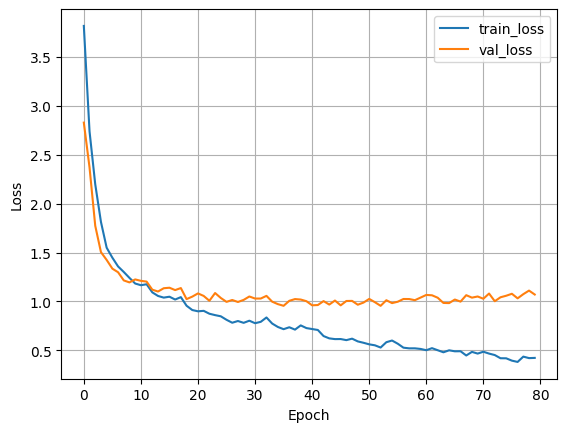

In [32]:
model = Emformer_Classifier(input_dim=256,activation='relu').to('cuda:5')
print(f"Number of parameters: {count_params(model)}")

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

train_model(model, train_dataloader, val_dataloader, num_epochs=80, num_eval_epoch=1, 
            criterion=None, optimizer=optimizer, scheduler=None, 
            save_dir = "/data/pitch_estimation/Emformer_MIR1k", gpu_number = 5)

plot_loss("/data/pitch_estimation/Emformer_MIR1k")

In [ ]:
model = Emformer_Classifier(input_dim=256, num_layers=4).to('cuda:5')
print(f"Number of parameters: {count_params(model)}")

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40], gamma=0.5)


train_model(model, train_dataloader, val_dataloader, num_epochs=50, num_eval_epoch=1, 
            criterion=None, optimizer=optimizer, scheduler=scheduler, 
            save_dir = "/data/pitch_estimation/Emformer_MIR1k_bs64_small", gpu_number = 5)

plot_loss("/data/pitch_estimation/Emformer_MIR1k_bs64_small")

NameError: name 'Emformer' is not defined

Number of parameters: 3253865
Using device: cuda:5


100%|██████████| 14/14 [00:01<00:00,  8.47it/s]


Epoch 1/50, Loss: 3.2466032845633372


100%|██████████| 13/13 [00:00<00:00, 48.64it/s]


Epoch: 0 Validation Loss: 1.8769290482997893, Validation Accuracy: None
Best model saved at epoch 0, val loss: 1.8769290482997893


100%|██████████| 14/14 [00:00<00:00, 15.90it/s]


Epoch 2/50, Loss: 1.7910103116716658


100%|██████████| 13/13 [00:00<00:00, 49.71it/s]


Epoch: 1 Validation Loss: 1.4274245965480805, Validation Accuracy: None
Best model saved at epoch 1, val loss: 1.4274245965480805


100%|██████████| 14/14 [00:00<00:00, 15.13it/s]


Epoch 3/50, Loss: 1.5188092504228865


100%|██████████| 13/13 [00:00<00:00, 40.88it/s]


Epoch: 2 Validation Loss: 1.324057788848877, Validation Accuracy: None
Best model saved at epoch 2, val loss: 1.324057788848877


100%|██████████| 14/14 [00:00<00:00, 15.28it/s]


Epoch 4/50, Loss: 1.3333987423351832


100%|██████████| 13/13 [00:00<00:00, 49.58it/s]


Epoch: 3 Validation Loss: 1.2659780210256577, Validation Accuracy: None
Best model saved at epoch 3, val loss: 1.2659780210256577


100%|██████████| 14/14 [00:00<00:00, 15.36it/s]


Epoch 5/50, Loss: 1.2790778279304504


100%|██████████| 13/13 [00:00<00:00, 49.58it/s]


Epoch: 4 Validation Loss: 1.2274830007553101, Validation Accuracy: None
Best model saved at epoch 4, val loss: 1.2274830007553101


100%|██████████| 14/14 [00:00<00:00, 16.36it/s]


Epoch 6/50, Loss: 1.2378704633031572


100%|██████████| 13/13 [00:00<00:00, 49.42it/s]


Epoch: 5 Validation Loss: 1.2582307374477386, Validation Accuracy: None


100%|██████████| 14/14 [00:00<00:00, 16.39it/s]


Epoch 7/50, Loss: 1.2443541884422302


100%|██████████| 13/13 [00:00<00:00, 50.45it/s]


Epoch: 6 Validation Loss: 1.2097783195972442, Validation Accuracy: None
Best model saved at epoch 6, val loss: 1.2097783195972442


100%|██████████| 14/14 [00:00<00:00, 16.27it/s]


Epoch 8/50, Loss: 1.208549780505044


100%|██████████| 13/13 [00:00<00:00, 43.23it/s]


Epoch: 7 Validation Loss: 1.1735969966650008, Validation Accuracy: None
Best model saved at epoch 7, val loss: 1.1735969966650008


100%|██████████| 14/14 [00:00<00:00, 15.38it/s]


Epoch 9/50, Loss: 1.1429109701088496


100%|██████████| 13/13 [00:00<00:00, 38.95it/s]


Epoch: 8 Validation Loss: 1.157708062529564, Validation Accuracy: None
Best model saved at epoch 8, val loss: 1.157708062529564


100%|██████████| 14/14 [00:00<00:00, 16.13it/s]


Epoch 10/50, Loss: 1.0878772352422987


100%|██████████| 13/13 [00:00<00:00, 49.29it/s]


Epoch: 9 Validation Loss: 1.1105071169137954, Validation Accuracy: None
Best model saved at epoch 9, val loss: 1.1105071169137954


100%|██████████| 14/14 [00:00<00:00, 16.75it/s]


Epoch 11/50, Loss: 1.070490449666977


100%|██████████| 13/13 [00:00<00:00, 49.17it/s]


Epoch: 10 Validation Loss: 1.1032428079843521, Validation Accuracy: None
Best model saved at epoch 10, val loss: 1.1032428079843521


100%|██████████| 14/14 [00:00<00:00, 17.21it/s]


Epoch 12/50, Loss: 1.0674685622964586


100%|██████████| 13/13 [00:00<00:00, 49.26it/s]


Epoch: 11 Validation Loss: 1.1289924663305282, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.08it/s]


Epoch 13/50, Loss: 1.049162745475769


100%|██████████| 13/13 [00:00<00:00, 33.84it/s]


Epoch: 12 Validation Loss: 1.0968157154321672, Validation Accuracy: None
Best model saved at epoch 12, val loss: 1.0968157154321672


100%|██████████| 14/14 [00:01<00:00, 13.62it/s]


Epoch 14/50, Loss: 1.0186210870742798


100%|██████████| 13/13 [00:00<00:00, 42.90it/s]


Epoch: 13 Validation Loss: 1.08837848842144, Validation Accuracy: None
Best model saved at epoch 13, val loss: 1.08837848842144


100%|██████████| 14/14 [00:01<00:00, 13.77it/s]


Epoch 15/50, Loss: 1.0217601912362235


100%|██████████| 13/13 [00:00<00:00, 42.98it/s]


Epoch: 14 Validation Loss: 1.0903486049175262, Validation Accuracy: None


100%|██████████| 14/14 [00:00<00:00, 14.32it/s]


Epoch 16/50, Loss: 0.9730697785105024


100%|██████████| 13/13 [00:00<00:00, 47.83it/s]


Epoch: 15 Validation Loss: 1.1001530104875565, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.81it/s]


Epoch 17/50, Loss: 0.9211367155824389


100%|██████████| 13/13 [00:00<00:00, 53.96it/s]


Epoch: 16 Validation Loss: 1.046741264462471, Validation Accuracy: None
Best model saved at epoch 16, val loss: 1.046741264462471


100%|██████████| 14/14 [00:01<00:00, 13.65it/s]


Epoch 18/50, Loss: 0.8732456735202244


100%|██████████| 13/13 [00:00<00:00, 53.24it/s]


Epoch: 17 Validation Loss: 1.0412959134578705, Validation Accuracy: None
Best model saved at epoch 17, val loss: 1.0412959134578705


100%|██████████| 14/14 [00:01<00:00, 13.77it/s]


Epoch 19/50, Loss: 0.848758625132697


100%|██████████| 13/13 [00:00<00:00, 52.74it/s]


Epoch: 18 Validation Loss: 1.0164159643650055, Validation Accuracy: None
Best model saved at epoch 18, val loss: 1.0164159643650055


100%|██████████| 14/14 [00:00<00:00, 14.35it/s]


Epoch 20/50, Loss: 0.9326998974595752


100%|██████████| 13/13 [00:00<00:00, 48.90it/s]


Epoch: 19 Validation Loss: 1.0684878271818161, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.54it/s]


Epoch 21/50, Loss: 0.8531568603856223


100%|██████████| 13/13 [00:00<00:00, 54.12it/s]


Epoch: 20 Validation Loss: 1.0141178739070893, Validation Accuracy: None
Best model saved at epoch 20, val loss: 1.0141178739070893


100%|██████████| 14/14 [00:00<00:00, 15.06it/s]


Epoch 22/50, Loss: 0.8250439209597451


100%|██████████| 13/13 [00:00<00:00, 54.07it/s]


Epoch: 21 Validation Loss: 0.9969430720806122, Validation Accuracy: None
Best model saved at epoch 21, val loss: 0.9969430720806122


100%|██████████| 14/14 [00:00<00:00, 15.53it/s]


Epoch 23/50, Loss: 0.7516561065401349


100%|██████████| 13/13 [00:00<00:00, 53.61it/s]


Epoch: 22 Validation Loss: 0.9727950239181519, Validation Accuracy: None
Best model saved at epoch 22, val loss: 0.9727950239181519


100%|██████████| 14/14 [00:00<00:00, 16.24it/s]


Epoch 24/50, Loss: 0.7919129601546696


100%|██████████| 13/13 [00:00<00:00, 40.32it/s]


Epoch: 23 Validation Loss: 1.002454037666321, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.73it/s]


Epoch 25/50, Loss: 0.7474375580038343


100%|██████████| 13/13 [00:00<00:00, 39.62it/s]


Epoch: 24 Validation Loss: 0.9925873160362244, Validation Accuracy: None


100%|██████████| 14/14 [00:00<00:00, 15.43it/s]


Epoch 26/50, Loss: 0.790520748921803


100%|██████████| 13/13 [00:00<00:00, 50.07it/s]


Epoch: 25 Validation Loss: 0.9956458103656769, Validation Accuracy: None


100%|██████████| 14/14 [00:00<00:00, 15.54it/s]


Epoch 27/50, Loss: 0.7647563346794674


100%|██████████| 13/13 [00:00<00:00, 50.17it/s]


Epoch: 26 Validation Loss: 0.9631273621320724, Validation Accuracy: None
Best model saved at epoch 26, val loss: 0.9631273621320724


100%|██████████| 14/14 [00:00<00:00, 15.28it/s]


Epoch 28/50, Loss: 0.7463586585862296


100%|██████████| 13/13 [00:00<00:00, 50.05it/s]


Epoch: 27 Validation Loss: 0.9831462600827217, Validation Accuracy: None


100%|██████████| 14/14 [00:00<00:00, 15.36it/s]


Epoch 29/50, Loss: 0.7329523307936532


100%|██████████| 13/13 [00:00<00:00, 49.88it/s]


Epoch: 28 Validation Loss: 0.9725582244992256, Validation Accuracy: None


100%|██████████| 14/14 [00:00<00:00, 15.26it/s]


Epoch 30/50, Loss: 0.7006804559912


100%|██████████| 13/13 [00:00<00:00, 48.72it/s]


Epoch: 29 Validation Loss: 0.9848764705657959, Validation Accuracy: None


100%|██████████| 14/14 [00:00<00:00, 14.92it/s]


Epoch 31/50, Loss: 0.6641672764505658


100%|██████████| 13/13 [00:00<00:00, 47.81it/s]


Epoch: 30 Validation Loss: 0.953582020998001, Validation Accuracy: None
Best model saved at epoch 30, val loss: 0.953582020998001


100%|██████████| 14/14 [00:00<00:00, 15.00it/s]


Epoch 32/50, Loss: 0.6467534601688385


100%|██████████| 13/13 [00:00<00:00, 48.28it/s]


Epoch: 31 Validation Loss: 0.9595516362786293, Validation Accuracy: None


100%|██████████| 14/14 [00:00<00:00, 14.13it/s]


Epoch 33/50, Loss: 0.6603492072650364


100%|██████████| 13/13 [00:00<00:00, 53.39it/s]


Epoch: 32 Validation Loss: 0.9838359394669532, Validation Accuracy: None


100%|██████████| 14/14 [00:00<00:00, 14.95it/s]


Epoch 34/50, Loss: 0.633378552539008


100%|██████████| 13/13 [00:00<00:00, 53.46it/s]


Epoch: 33 Validation Loss: 0.974330216050148, Validation Accuracy: None


100%|██████████| 14/14 [00:00<00:00, 15.29it/s]


Epoch 35/50, Loss: 0.6531851163932255


100%|██████████| 13/13 [00:00<00:00, 53.97it/s]


Epoch: 34 Validation Loss: 0.9805207076668739, Validation Accuracy: None


100%|██████████| 14/14 [00:00<00:00, 14.98it/s]


Epoch 36/50, Loss: 0.6507582536765507


100%|██████████| 13/13 [00:00<00:00, 53.92it/s]


Epoch: 35 Validation Loss: 0.9747559183835983, Validation Accuracy: None


100%|██████████| 14/14 [00:00<00:00, 14.32it/s]


Epoch 37/50, Loss: 0.6647584310599736


100%|██████████| 13/13 [00:00<00:00, 53.55it/s]


Epoch: 36 Validation Loss: 0.9805477064847946, Validation Accuracy: None


100%|██████████| 14/14 [00:00<00:00, 14.59it/s]


Epoch 38/50, Loss: 0.6253101527690887


100%|██████████| 13/13 [00:00<00:00, 53.51it/s]


Epoch: 37 Validation Loss: 0.9870542576909065, Validation Accuracy: None


100%|██████████| 14/14 [00:00<00:00, 14.86it/s]


Epoch 39/50, Loss: 0.637330915246691


100%|██████████| 13/13 [00:00<00:00, 53.21it/s]


Epoch: 38 Validation Loss: 0.9921959975361824, Validation Accuracy: None


100%|██████████| 14/14 [00:00<00:00, 14.46it/s]


Epoch 40/50, Loss: 0.6431879486356463


100%|██████████| 13/13 [00:00<00:00, 53.32it/s]


Epoch: 39 Validation Loss: 0.9559815162420273, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.71it/s]


Epoch 41/50, Loss: 0.6031285439218793


100%|██████████| 13/13 [00:00<00:00, 53.18it/s]


Epoch: 40 Validation Loss: 0.9557865875959396, Validation Accuracy: None


100%|██████████| 14/14 [00:00<00:00, 14.81it/s]


Epoch 42/50, Loss: 0.6102818208081382


100%|██████████| 13/13 [00:00<00:00, 53.53it/s]


Epoch: 41 Validation Loss: 0.9620518651604653, Validation Accuracy: None


100%|██████████| 14/14 [00:00<00:00, 14.60it/s]


Epoch 43/50, Loss: 0.5866857554231372


100%|██████████| 13/13 [00:00<00:00, 53.08it/s]


Epoch: 42 Validation Loss: 0.9607191351056099, Validation Accuracy: None


100%|██████████| 14/14 [00:00<00:00, 14.67it/s]


Epoch 44/50, Loss: 0.6103884705475399


100%|██████████| 13/13 [00:00<00:00, 51.15it/s]


Epoch: 43 Validation Loss: 0.9743455785512924, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.80it/s]


Epoch 45/50, Loss: 0.5948353622640882


100%|██████████| 13/13 [00:00<00:00, 31.71it/s]


Epoch: 44 Validation Loss: 0.9735681203007698, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.77it/s]


Epoch 46/50, Loss: 0.5940722908292498


100%|██████████| 13/13 [00:00<00:00, 44.47it/s]


Epoch: 45 Validation Loss: 0.9638780242204666, Validation Accuracy: None


100%|██████████| 14/14 [00:00<00:00, 15.67it/s]


Epoch 47/50, Loss: 0.588532098702022


100%|██████████| 13/13 [00:00<00:00, 51.45it/s]


Epoch: 46 Validation Loss: 0.9885265508294105, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.78it/s]


Epoch 48/50, Loss: 0.5703074634075165


100%|██████████| 13/13 [00:00<00:00, 51.15it/s]


Epoch: 47 Validation Loss: 0.965792461335659, Validation Accuracy: None


100%|██████████| 14/14 [00:00<00:00, 14.40it/s]


Epoch 49/50, Loss: 0.588125331061227


100%|██████████| 13/13 [00:00<00:00, 46.50it/s]


Epoch: 48 Validation Loss: 0.9647645637392998, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.40it/s]


Epoch 50/50, Loss: 0.5693995228835514


100%|██████████| 13/13 [00:00<00:00, 31.30it/s]


Epoch: 49 Validation Loss: 0.9784177505970001, Validation Accuracy: None


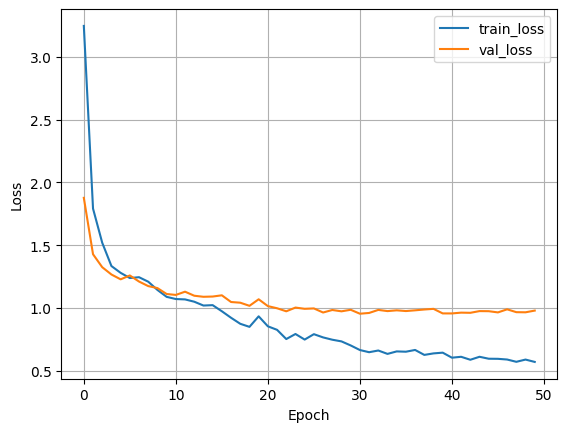

In [20]:
model = Emformer_Classifier(input_dim=256, num_layers=4).to('cuda:5')
print(f"Number of parameters: {count_params(model)}")

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40], gamma=0.5)


train_model(model, train_dataloader, val_dataloader, num_epochs=50, num_eval_epoch=1, 
            criterion=None, optimizer=optimizer, scheduler=scheduler, 
            save_dir = "/data/pitch_estimation/Emformer_MIR1k_bs64_small", gpu_number = 5)

plot_loss("/data/pitch_estimation/Emformer_MIR1k_bs64_small")

Number of parameters: 4834409
Using device: cuda:5


100%|██████████| 14/14 [00:01<00:00, 12.82it/s]


Epoch 1/100, Loss: 2.855149269104004


100%|██████████| 13/13 [00:00<00:00, 44.91it/s]


Epoch: 0 Validation Loss: 1.6833200395107268, Validation Accuracy: None
Best model saved at epoch 0, val loss: 1.6833200395107268


100%|██████████| 14/14 [00:01<00:00, 13.51it/s]


Epoch 2/100, Loss: 1.6798459121159144


100%|██████████| 13/13 [00:00<00:00, 45.05it/s]


Epoch: 1 Validation Loss: 1.426116591691971, Validation Accuracy: None
Best model saved at epoch 1, val loss: 1.426116591691971


100%|██████████| 14/14 [00:00<00:00, 14.83it/s]


Epoch 3/100, Loss: 1.4815834334918432


100%|██████████| 13/13 [00:00<00:00, 45.00it/s]


Epoch: 2 Validation Loss: 1.3425641000270843, Validation Accuracy: None
Best model saved at epoch 2, val loss: 1.3425641000270843


100%|██████████| 14/14 [00:01<00:00, 12.99it/s]


Epoch 4/100, Loss: 1.384145506790706


100%|██████████| 13/13 [00:00<00:00, 44.93it/s]


Epoch: 3 Validation Loss: 1.315263226032257, Validation Accuracy: None
Best model saved at epoch 3, val loss: 1.315263226032257


100%|██████████| 14/14 [00:01<00:00, 12.92it/s]


Epoch 5/100, Loss: 1.2701044423239571


100%|██████████| 13/13 [00:00<00:00, 44.50it/s]


Epoch: 4 Validation Loss: 1.25209321975708, Validation Accuracy: None
Best model saved at epoch 4, val loss: 1.25209321975708


100%|██████████| 14/14 [00:01<00:00, 13.50it/s]


Epoch 6/100, Loss: 1.2898480125835963


100%|██████████| 13/13 [00:00<00:00, 44.36it/s]


Epoch: 5 Validation Loss: 1.226990532875061, Validation Accuracy: None
Best model saved at epoch 5, val loss: 1.226990532875061


100%|██████████| 14/14 [00:01<00:00, 11.95it/s]


Epoch 7/100, Loss: 1.2284139905657088


100%|██████████| 13/13 [00:00<00:00, 43.03it/s]


Epoch: 6 Validation Loss: 1.194708487391472, Validation Accuracy: None
Best model saved at epoch 6, val loss: 1.194708487391472


100%|██████████| 14/14 [00:01<00:00, 12.63it/s]


Epoch 8/100, Loss: 1.1758968915258134


100%|██████████| 13/13 [00:00<00:00, 39.07it/s]


Epoch: 7 Validation Loss: 1.1580496710538863, Validation Accuracy: None
Best model saved at epoch 7, val loss: 1.1580496710538863


100%|██████████| 14/14 [00:01<00:00, 11.59it/s]


Epoch 9/100, Loss: 1.1490550892693656


100%|██████████| 13/13 [00:00<00:00, 43.36it/s]


Epoch: 8 Validation Loss: 1.1303653383255006, Validation Accuracy: None
Best model saved at epoch 8, val loss: 1.1303653383255006


100%|██████████| 14/14 [00:01<00:00, 12.94it/s]


Epoch 10/100, Loss: 1.1297673370156969


100%|██████████| 13/13 [00:00<00:00, 43.37it/s]


Epoch: 9 Validation Loss: 1.1782878357172013, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.65it/s]


Epoch 11/100, Loss: 1.1181972750595637


100%|██████████| 13/13 [00:00<00:00, 43.63it/s]


Epoch: 10 Validation Loss: 1.1404367417097092, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.42it/s]


Epoch 12/100, Loss: 1.0831959247589111


100%|██████████| 13/13 [00:00<00:00, 43.26it/s]


Epoch: 11 Validation Loss: 1.1127976936101913, Validation Accuracy: None
Best model saved at epoch 11, val loss: 1.1127976936101913


100%|██████████| 14/14 [00:01<00:00, 13.58it/s]


Epoch 13/100, Loss: 1.0257897121565682


100%|██████████| 13/13 [00:00<00:00, 40.54it/s]


Epoch: 12 Validation Loss: 1.0532302361726762, Validation Accuracy: None
Best model saved at epoch 12, val loss: 1.0532302361726762


100%|██████████| 14/14 [00:01<00:00, 12.96it/s]


Epoch 14/100, Loss: 1.011025220155716


100%|██████████| 13/13 [00:00<00:00, 43.29it/s]


Epoch: 13 Validation Loss: 1.0700222480297088, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.13it/s]


Epoch 15/100, Loss: 1.0358543864318304


100%|██████████| 13/13 [00:00<00:00, 43.34it/s]


Epoch: 14 Validation Loss: 1.1334728270769119, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.97it/s]


Epoch 16/100, Loss: 1.0003375921930586


100%|██████████| 13/13 [00:00<00:00, 37.94it/s]


Epoch: 15 Validation Loss: 1.097044426202774, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.20it/s]


Epoch 17/100, Loss: 0.9754491065229688


100%|██████████| 13/13 [00:00<00:00, 30.95it/s]


Epoch: 16 Validation Loss: 1.0831940364837647, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.81it/s]


Epoch 18/100, Loss: 0.9173873577799115


100%|██████████| 13/13 [00:00<00:00, 39.42it/s]


Epoch: 17 Validation Loss: 1.0999050897359848, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.40it/s]


Epoch 19/100, Loss: 0.9410544037818909


100%|██████████| 13/13 [00:00<00:00, 44.75it/s]


Epoch: 18 Validation Loss: 1.074625313282013, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.83it/s]


Epoch 20/100, Loss: 0.9353120114122119


100%|██████████| 13/13 [00:00<00:00, 43.63it/s]


Epoch: 19 Validation Loss: 1.0860575276613236, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.59it/s]


Epoch 21/100, Loss: 0.9103277793952397


100%|██████████| 13/13 [00:00<00:00, 32.67it/s]


Epoch: 20 Validation Loss: 1.0118436014652252, Validation Accuracy: None
Best model saved at epoch 20, val loss: 1.0118436014652252


100%|██████████| 14/14 [00:01<00:00, 11.08it/s]


Epoch 22/100, Loss: 0.82566727910723


100%|██████████| 13/13 [00:00<00:00, 38.74it/s]


Epoch: 21 Validation Loss: 0.9527948296070099, Validation Accuracy: None
Best model saved at epoch 21, val loss: 0.9527948296070099


100%|██████████| 14/14 [00:01<00:00, 11.54it/s]


Epoch 23/100, Loss: 0.7785312235355377


100%|██████████| 13/13 [00:00<00:00, 43.50it/s]


Epoch: 22 Validation Loss: 0.9830738800764084, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.40it/s]


Epoch 24/100, Loss: 0.7919228204659053


100%|██████████| 13/13 [00:00<00:00, 43.83it/s]


Epoch: 23 Validation Loss: 0.9528671950101852, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.39it/s]


Epoch 25/100, Loss: 0.7660103780882699


100%|██████████| 13/13 [00:00<00:00, 43.88it/s]


Epoch: 24 Validation Loss: 0.9803499448299408, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.21it/s]


Epoch 26/100, Loss: 0.755227621112551


100%|██████████| 13/13 [00:00<00:00, 43.98it/s]


Epoch: 25 Validation Loss: 0.9640552332997322, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.50it/s]


Epoch 27/100, Loss: 0.7331087802137647


100%|██████████| 13/13 [00:00<00:00, 38.61it/s]


Epoch: 26 Validation Loss: 0.975863025188446, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.64it/s]


Epoch 28/100, Loss: 0.7409909197262355


100%|██████████| 13/13 [00:00<00:00, 43.85it/s]


Epoch: 27 Validation Loss: 0.9182985013723374, Validation Accuracy: None
Best model saved at epoch 27, val loss: 0.9182985013723374


100%|██████████| 14/14 [00:01<00:00, 11.03it/s]


Epoch 29/100, Loss: 0.7072136572429112


100%|██████████| 13/13 [00:00<00:00, 43.52it/s]


Epoch: 28 Validation Loss: 0.9471394896507264, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.36it/s]


Epoch 30/100, Loss: 0.7102966734341213


100%|██████████| 13/13 [00:00<00:00, 43.87it/s]


Epoch: 29 Validation Loss: 0.9829873675107956, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.12it/s]


Epoch 31/100, Loss: 0.665695288351604


100%|██████████| 13/13 [00:00<00:00, 43.94it/s]


Epoch: 30 Validation Loss: 0.9462316340208053, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.19it/s]


Epoch 32/100, Loss: 0.6735056510993412


100%|██████████| 13/13 [00:00<00:00, 38.85it/s]


Epoch: 31 Validation Loss: 0.955149849653244, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.88it/s]


Epoch 33/100, Loss: 0.6675126510007041


100%|██████████| 13/13 [00:00<00:00, 41.71it/s]


Epoch: 32 Validation Loss: 0.9363711935281753, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.75it/s]


Epoch 34/100, Loss: 0.648216975586755


100%|██████████| 13/13 [00:00<00:00, 40.90it/s]


Epoch: 33 Validation Loss: 0.9270433816313743, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.25it/s]


Epoch 35/100, Loss: 0.6281112645353589


100%|██████████| 13/13 [00:00<00:00, 39.39it/s]


Epoch: 34 Validation Loss: 0.9201972031593323, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.16it/s]


Epoch 36/100, Loss: 0.6691977211407253


100%|██████████| 13/13 [00:00<00:00, 40.53it/s]


Epoch: 35 Validation Loss: 0.9116453060507774, Validation Accuracy: None
Best model saved at epoch 35, val loss: 0.9116453060507774


100%|██████████| 14/14 [00:01<00:00, 11.70it/s]


Epoch 37/100, Loss: 0.6572579869202205


100%|██████████| 13/13 [00:00<00:00, 41.21it/s]


Epoch: 36 Validation Loss: 0.9215384602546692, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.82it/s]


Epoch 38/100, Loss: 0.6486455244677407


100%|██████████| 13/13 [00:00<00:00, 34.63it/s]


Epoch: 37 Validation Loss: 0.9267245811223984, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.08it/s]


Epoch 39/100, Loss: 0.6185847478253501


100%|██████████| 13/13 [00:00<00:00, 44.12it/s]


Epoch: 38 Validation Loss: 0.9208082127571106, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.06it/s]


Epoch 40/100, Loss: 0.6018296820776803


100%|██████████| 13/13 [00:00<00:00, 42.43it/s]


Epoch: 39 Validation Loss: 0.9271820548176766, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.45it/s]


Epoch 41/100, Loss: 0.6257951813084739


100%|██████████| 13/13 [00:00<00:00, 42.38it/s]


Epoch: 40 Validation Loss: 0.9291438308358192, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.92it/s]


Epoch 42/100, Loss: 0.5994094397340503


100%|██████████| 13/13 [00:00<00:00, 37.19it/s]


Epoch: 41 Validation Loss: 0.9142559364438057, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.97it/s]


Epoch 43/100, Loss: 0.5948507402624402


100%|██████████| 13/13 [00:00<00:00, 41.86it/s]


Epoch: 42 Validation Loss: 0.9113267910480499, Validation Accuracy: None
Best model saved at epoch 42, val loss: 0.9113267910480499


100%|██████████| 14/14 [00:01<00:00, 12.00it/s]


Epoch 44/100, Loss: 0.5692654039178576


100%|██████████| 13/13 [00:00<00:00, 43.34it/s]


Epoch: 43 Validation Loss: 0.9134347835183143, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.41it/s]


Epoch 45/100, Loss: 0.5652721651962825


100%|██████████| 13/13 [00:00<00:00, 36.16it/s]


Epoch: 44 Validation Loss: 0.9142535555362702, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.13it/s]


Epoch 46/100, Loss: 0.5798260569572449


100%|██████████| 13/13 [00:00<00:00, 36.74it/s]


Epoch: 45 Validation Loss: 0.9194426301121712, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.89it/s]


Epoch 47/100, Loss: 0.5659420596701759


100%|██████████| 13/13 [00:00<00:00, 41.72it/s]


Epoch: 46 Validation Loss: 0.9250797295570373, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.26it/s]


Epoch 48/100, Loss: 0.5796430174793515


100%|██████████| 13/13 [00:00<00:00, 41.67it/s]


Epoch: 47 Validation Loss: 0.928932029902935, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.54it/s]


Epoch 49/100, Loss: 0.5646625884941646


100%|██████████| 13/13 [00:00<00:00, 42.56it/s]


Epoch: 48 Validation Loss: 0.9308584162592888, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.29it/s]


Epoch 50/100, Loss: 0.5389112170253482


100%|██████████| 13/13 [00:00<00:00, 43.23it/s]


Epoch: 49 Validation Loss: 0.9188402053713799, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.52it/s]


Epoch 51/100, Loss: 0.5468158040727887


100%|██████████| 13/13 [00:00<00:00, 42.94it/s]


Epoch: 50 Validation Loss: 0.9291435235738754, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.17it/s]


Epoch 52/100, Loss: 0.5461135868515287


100%|██████████| 13/13 [00:00<00:00, 42.40it/s]


Epoch: 51 Validation Loss: 0.9281188896298409, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.01it/s]


Epoch 53/100, Loss: 0.5328308854784284


100%|██████████| 13/13 [00:00<00:00, 37.09it/s]


Epoch: 52 Validation Loss: 0.9318433028459548, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.87it/s]


Epoch 54/100, Loss: 0.530771791934967


100%|██████████| 13/13 [00:00<00:00, 41.21it/s]


Epoch: 53 Validation Loss: 0.9411187088489532, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.61it/s]


Epoch 55/100, Loss: 0.5277826700891767


100%|██████████| 13/13 [00:00<00:00, 42.42it/s]


Epoch: 54 Validation Loss: 0.9267702239751816, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.03it/s]


Epoch 56/100, Loss: 0.5538034779684884


100%|██████████| 13/13 [00:00<00:00, 41.53it/s]


Epoch: 55 Validation Loss: 0.9278950199484826, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.11it/s]


Epoch 57/100, Loss: 0.5515358235154834


100%|██████████| 13/13 [00:00<00:00, 42.03it/s]


Epoch: 56 Validation Loss: 0.9419374352693558, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.76it/s]


Epoch 58/100, Loss: 0.5562167146376201


100%|██████████| 13/13 [00:00<00:00, 33.99it/s]


Epoch: 57 Validation Loss: 0.925609178841114, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.74it/s]


Epoch 59/100, Loss: 0.5033983992678779


100%|██████████| 13/13 [00:00<00:00, 36.22it/s]


Epoch: 58 Validation Loss: 0.9385031595826149, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.06it/s]


Epoch 60/100, Loss: 0.5194189122744969


100%|██████████| 13/13 [00:00<00:00, 41.00it/s]


Epoch: 59 Validation Loss: 0.9401153910160065, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.31it/s]


Epoch 61/100, Loss: 0.5145092159509659


100%|██████████| 13/13 [00:00<00:00, 40.81it/s]


Epoch: 60 Validation Loss: 0.9445917403697968, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.36it/s]


Epoch 62/100, Loss: 0.512116327881813


100%|██████████| 13/13 [00:00<00:00, 38.48it/s]


Epoch: 61 Validation Loss: 0.946729207932949, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.58it/s]


Epoch 63/100, Loss: 0.5451957349266324


100%|██████████| 13/13 [00:00<00:00, 35.53it/s]


Epoch: 62 Validation Loss: 0.933878298997879, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.12it/s]


Epoch 64/100, Loss: 0.5154436635119575


100%|██████████| 13/13 [00:00<00:00, 43.07it/s]


Epoch: 63 Validation Loss: 0.9397849708795547, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.93it/s]


Epoch 65/100, Loss: 0.514981318797384


100%|██████████| 13/13 [00:00<00:00, 42.64it/s]


Epoch: 64 Validation Loss: 0.9361488690972328, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.08it/s]


Epoch 66/100, Loss: 0.49028525395052774


100%|██████████| 13/13 [00:00<00:00, 43.15it/s]


Epoch: 65 Validation Loss: 0.9355825012922288, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.64it/s]


Epoch 67/100, Loss: 0.5074718956436429


100%|██████████| 13/13 [00:00<00:00, 42.12it/s]


Epoch: 66 Validation Loss: 0.9464017841219902, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.67it/s]


Epoch 68/100, Loss: 0.5010056453091758


100%|██████████| 13/13 [00:00<00:00, 42.57it/s]


Epoch: 67 Validation Loss: 0.9551627513766289, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.08it/s]


Epoch 69/100, Loss: 0.48335779351847513


100%|██████████| 13/13 [00:00<00:00, 39.73it/s]


Epoch: 68 Validation Loss: 0.9493043714761734, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.46it/s]


Epoch 70/100, Loss: 0.4881077366215842


100%|██████████| 13/13 [00:00<00:00, 43.54it/s]


Epoch: 69 Validation Loss: 0.9379776301980018, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.55it/s]


Epoch 71/100, Loss: 0.489510110446385


100%|██████████| 13/13 [00:00<00:00, 43.14it/s]


Epoch: 70 Validation Loss: 0.9501907366514206, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.01it/s]


Epoch 72/100, Loss: 0.5117253618580955


100%|██████████| 13/13 [00:00<00:00, 36.04it/s]


Epoch: 71 Validation Loss: 0.9346916118264198, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.68it/s]


Epoch 73/100, Loss: 0.49758680377687725


100%|██████████| 13/13 [00:00<00:00, 39.70it/s]


Epoch: 72 Validation Loss: 0.959044114947319, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.91it/s]


Epoch 74/100, Loss: 0.4961929257426943


100%|██████████| 13/13 [00:00<00:00, 43.05it/s]


Epoch: 73 Validation Loss: 0.955670305788517, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.86it/s]


Epoch 75/100, Loss: 0.4892205468245915


100%|██████████| 13/13 [00:00<00:00, 44.31it/s]


Epoch: 74 Validation Loss: 0.9584713712334633, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.59it/s]


Epoch 76/100, Loss: 0.48259309359959196


100%|██████████| 13/13 [00:00<00:00, 44.86it/s]


Epoch: 75 Validation Loss: 0.9585297498106956, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.93it/s]


Epoch 77/100, Loss: 0.4851240026099341


100%|██████████| 13/13 [00:00<00:00, 42.46it/s]


Epoch: 76 Validation Loss: 0.93785481184721, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.44it/s]


Epoch 78/100, Loss: 0.49740189739636015


100%|██████████| 13/13 [00:00<00:00, 37.26it/s]


Epoch: 77 Validation Loss: 0.9588211023807526, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.28it/s]


Epoch 79/100, Loss: 0.49001504480838776


100%|██████████| 13/13 [00:00<00:00, 44.70it/s]


Epoch: 78 Validation Loss: 0.9455513563752175, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.80it/s]


Epoch 80/100, Loss: 0.46945808827877045


100%|██████████| 13/13 [00:00<00:00, 44.65it/s]


Epoch: 79 Validation Loss: 0.9469259029626846, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.67it/s]


Epoch 81/100, Loss: 0.446230628660747


100%|██████████| 13/13 [00:00<00:00, 44.45it/s]


Epoch: 80 Validation Loss: 0.9488787490129471, Validation Accuracy: None


100%|██████████| 14/14 [00:00<00:00, 14.01it/s]


Epoch 82/100, Loss: 0.43933049057211193


100%|██████████| 13/13 [00:00<00:00, 44.97it/s]


Epoch: 81 Validation Loss: 0.9583986857533455, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.72it/s]


Epoch 83/100, Loss: 0.4649706504174641


100%|██████████| 13/13 [00:00<00:00, 44.79it/s]


Epoch: 82 Validation Loss: 0.9522614827752114, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.60it/s]


Epoch 84/100, Loss: 0.43950657759393963


100%|██████████| 13/13 [00:00<00:00, 44.76it/s]


Epoch: 83 Validation Loss: 0.9557206946611404, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.53it/s]


Epoch 85/100, Loss: 0.4478832504578999


100%|██████████| 13/13 [00:00<00:00, 44.36it/s]


Epoch: 84 Validation Loss: 0.9797462609410286, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.15it/s]


Epoch 86/100, Loss: 0.4346677767378943


100%|██████████| 13/13 [00:00<00:00, 44.86it/s]


Epoch: 85 Validation Loss: 0.9673905238509178, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.84it/s]


Epoch 87/100, Loss: 0.47157820207732065


100%|██████████| 13/13 [00:00<00:00, 44.74it/s]


Epoch: 86 Validation Loss: 0.9600919130444526, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.74it/s]


Epoch 88/100, Loss: 0.4636998964207513


100%|██████████| 13/13 [00:00<00:00, 40.05it/s]


Epoch: 87 Validation Loss: 0.9537211549282074, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.75it/s]


Epoch 89/100, Loss: 0.482419096997806


100%|██████████| 13/13 [00:00<00:00, 45.17it/s]


Epoch: 88 Validation Loss: 0.9766698029637336, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.92it/s]


Epoch 90/100, Loss: 0.45599234104156494


100%|██████████| 13/13 [00:00<00:00, 44.54it/s]


Epoch: 89 Validation Loss: 0.9772026601433754, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.02it/s]


Epoch 91/100, Loss: 0.4284753693001611


100%|██████████| 13/13 [00:00<00:00, 44.29it/s]


Epoch: 90 Validation Loss: 0.9732957616448402, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.54it/s]


Epoch 92/100, Loss: 0.4260406813451222


100%|██████████| 13/13 [00:00<00:00, 45.02it/s]


Epoch: 91 Validation Loss: 0.9722481355071068, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 10.81it/s]


Epoch 93/100, Loss: 0.4168864446026938


100%|██████████| 13/13 [00:00<00:00, 44.62it/s]


Epoch: 92 Validation Loss: 0.9956432753801345, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.04it/s]


Epoch 94/100, Loss: 0.4293125889131001


100%|██████████| 13/13 [00:00<00:00, 44.49it/s]


Epoch: 93 Validation Loss: 0.9751878267526627, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.75it/s]


Epoch 95/100, Loss: 0.4100452406065805


100%|██████████| 13/13 [00:00<00:00, 44.60it/s]


Epoch: 94 Validation Loss: 0.9901165455579758, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.73it/s]


Epoch 96/100, Loss: 0.45261746857847485


100%|██████████| 13/13 [00:00<00:00, 39.93it/s]


Epoch: 95 Validation Loss: 1.0035872635245324, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.26it/s]


Epoch 97/100, Loss: 0.4171107794557299


100%|██████████| 13/13 [00:00<00:00, 43.13it/s]


Epoch: 96 Validation Loss: 1.0099549299478532, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.51it/s]


Epoch 98/100, Loss: 0.4014168701001576


100%|██████████| 13/13 [00:00<00:00, 38.05it/s]


Epoch: 97 Validation Loss: 0.9955918127298355, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.38it/s]


Epoch 99/100, Loss: 0.41605280339717865


100%|██████████| 13/13 [00:00<00:00, 43.60it/s]


Epoch: 98 Validation Loss: 0.9895304352045059, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.12it/s]


Epoch 100/100, Loss: 0.3935257260288511


100%|██████████| 13/13 [00:00<00:00, 41.34it/s]


Epoch: 99 Validation Loss: 1.0023906457424163, Validation Accuracy: None


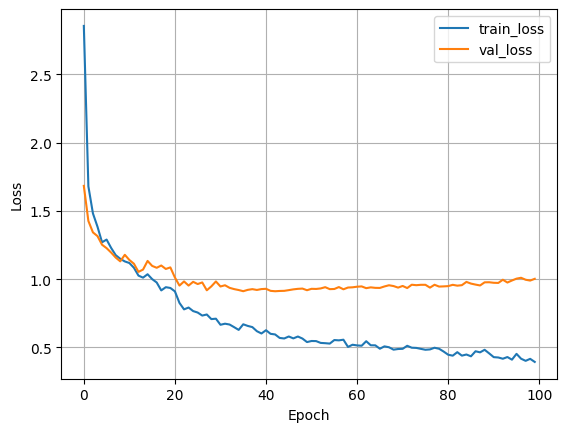

In [ ]:
model = Emformer_Classifier(input_dim=256, activation = 'gelu').to('cuda:5')
print(f"Number of parameters: {count_params(model)}")

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40], gamma=0.5)


train_model(model, train_dataloader, val_dataloader, num_epochs=100, num_eval_epoch=1, 
            criterion=None, optimizer=optimizer, scheduler=scheduler, 
            save_dir = "/data/pitch_estimation/Emformer_MIR1k_bs64_gelu", gpu_number = 5)

plot_loss("/data/pitch_estimation/Emformer_MIR1k_bs64_gelu")

Number of parameters: 4834409
Using device: cuda:5


100%|██████████| 14/14 [00:01<00:00, 12.66it/s]


Epoch 1/50, Loss: 3.1818578924451555


100%|██████████| 13/13 [00:00<00:00, 36.33it/s]


Epoch: 0 Validation Loss: 1.9151560497283935, Validation Accuracy: None
Best model saved at epoch 0, val loss: 1.9151560497283935


100%|██████████| 14/14 [00:01<00:00, 12.45it/s]


Epoch 2/50, Loss: 1.8213541507720947


100%|██████████| 13/13 [00:00<00:00, 36.09it/s]


Epoch: 1 Validation Loss: 1.4699667239189147, Validation Accuracy: None
Best model saved at epoch 1, val loss: 1.4699667239189147


100%|██████████| 14/14 [00:01<00:00, 13.24it/s]


Epoch 3/50, Loss: 1.492918678692409


100%|██████████| 13/13 [00:00<00:00, 36.27it/s]


Epoch: 2 Validation Loss: 1.333957589864731, Validation Accuracy: None
Best model saved at epoch 2, val loss: 1.333957589864731


100%|██████████| 14/14 [00:01<00:00, 12.75it/s]


Epoch 4/50, Loss: 1.381642528942653


100%|██████████| 13/13 [00:00<00:00, 36.15it/s]


Epoch: 3 Validation Loss: 1.2779760819673538, Validation Accuracy: None
Best model saved at epoch 3, val loss: 1.2779760819673538


100%|██████████| 14/14 [00:01<00:00, 13.07it/s]


Epoch 5/50, Loss: 1.3609493800571986


100%|██████████| 13/13 [00:00<00:00, 36.08it/s]


Epoch: 4 Validation Loss: 1.3227537965774536, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.67it/s]


Epoch 6/50, Loss: 1.2826871957097734


100%|██████████| 13/13 [00:00<00:00, 36.34it/s]


Epoch: 5 Validation Loss: 1.2102908432483672, Validation Accuracy: None
Best model saved at epoch 5, val loss: 1.2102908432483672


100%|██████████| 14/14 [00:01<00:00, 12.64it/s]


Epoch 7/50, Loss: 1.234111292021615


100%|██████████| 13/13 [00:00<00:00, 36.15it/s]


Epoch: 6 Validation Loss: 1.2388781893253327, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.61it/s]


Epoch 8/50, Loss: 1.2008395620754786


100%|██████████| 13/13 [00:00<00:00, 36.13it/s]


Epoch: 7 Validation Loss: 1.161845287680626, Validation Accuracy: None
Best model saved at epoch 7, val loss: 1.161845287680626


100%|██████████| 14/14 [00:01<00:00, 13.32it/s]


Epoch 9/50, Loss: 1.1551467265401567


100%|██████████| 13/13 [00:00<00:00, 36.16it/s]


Epoch: 8 Validation Loss: 1.2019945430755614, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.61it/s]


Epoch 10/50, Loss: 1.0995100353445326


100%|██████████| 13/13 [00:00<00:00, 36.16it/s]


Epoch: 9 Validation Loss: 1.109393422603607, Validation Accuracy: None
Best model saved at epoch 9, val loss: 1.109393422603607


100%|██████████| 14/14 [00:01<00:00, 12.11it/s]


Epoch 11/50, Loss: 1.0294746458530426


100%|██████████| 13/13 [00:00<00:00, 37.71it/s]


Epoch: 10 Validation Loss: 1.1563385421037673, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.08it/s]


Epoch 12/50, Loss: 1.0379237064293452


100%|██████████| 13/13 [00:00<00:00, 44.60it/s]


Epoch: 11 Validation Loss: 1.1068649649620057, Validation Accuracy: None
Best model saved at epoch 11, val loss: 1.1068649649620057


100%|██████████| 14/14 [00:01<00:00, 13.70it/s]


Epoch 13/50, Loss: 1.0500522937093462


100%|██████████| 13/13 [00:00<00:00, 43.35it/s]


Epoch: 12 Validation Loss: 1.1102911639213562, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.98it/s]


Epoch 14/50, Loss: 1.032715461083821


100%|██████████| 13/13 [00:00<00:00, 44.60it/s]


Epoch: 13 Validation Loss: 1.0985527288913728, Validation Accuracy: None
Best model saved at epoch 13, val loss: 1.0985527288913728


100%|██████████| 14/14 [00:01<00:00, 12.51it/s]


Epoch 15/50, Loss: 0.9677324593067169


100%|██████████| 13/13 [00:00<00:00, 44.76it/s]


Epoch: 14 Validation Loss: 1.0670585924386977, Validation Accuracy: None
Best model saved at epoch 14, val loss: 1.0670585924386977


100%|██████████| 14/14 [00:01<00:00, 13.02it/s]


Epoch 16/50, Loss: 0.9459279903343746


100%|██████████| 13/13 [00:00<00:00, 44.69it/s]


Epoch: 15 Validation Loss: 1.051868244409561, Validation Accuracy: None
Best model saved at epoch 15, val loss: 1.051868244409561


100%|██████████| 14/14 [00:01<00:00, 13.20it/s]


Epoch 17/50, Loss: 0.9185807832649776


100%|██████████| 13/13 [00:00<00:00, 44.52it/s]


Epoch: 16 Validation Loss: 1.0607631266117097, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 11.66it/s]


Epoch 18/50, Loss: 0.9367594761507851


100%|██████████| 13/13 [00:00<00:00, 44.35it/s]


Epoch: 17 Validation Loss: 1.0520969289541244, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.56it/s]


Epoch 19/50, Loss: 0.9040238176073346


100%|██████████| 13/13 [00:00<00:00, 44.48it/s]


Epoch: 18 Validation Loss: 1.032882878780365, Validation Accuracy: None
Best model saved at epoch 18, val loss: 1.032882878780365


100%|██████████| 14/14 [00:01<00:00, 13.79it/s]


Epoch 20/50, Loss: 0.8890511648995536


100%|██████████| 13/13 [00:00<00:00, 44.38it/s]


Epoch: 19 Validation Loss: 1.0413728046417237, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.60it/s]


Epoch 21/50, Loss: 0.8479089651788984


100%|██████████| 13/13 [00:00<00:00, 44.65it/s]


Epoch: 20 Validation Loss: 0.9826490700244903, Validation Accuracy: None
Best model saved at epoch 20, val loss: 0.9826490700244903


100%|██████████| 14/14 [00:01<00:00, 13.09it/s]


Epoch 22/50, Loss: 0.7982180203710284


100%|██████████| 13/13 [00:00<00:00, 44.80it/s]


Epoch: 21 Validation Loss: 0.9764814448356628, Validation Accuracy: None
Best model saved at epoch 21, val loss: 0.9764814448356628


100%|██████████| 14/14 [00:01<00:00, 13.21it/s]


Epoch 23/50, Loss: 0.7650400187288012


100%|██████████| 13/13 [00:00<00:00, 44.58it/s]


Epoch: 22 Validation Loss: 0.9991405373811721, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.80it/s]


Epoch 24/50, Loss: 0.8053305532251086


100%|██████████| 13/13 [00:00<00:00, 44.17it/s]


Epoch: 23 Validation Loss: 0.9575232389569283, Validation Accuracy: None
Best model saved at epoch 23, val loss: 0.9575232389569283


100%|██████████| 14/14 [00:01<00:00, 13.68it/s]


Epoch 25/50, Loss: 0.7588580506188529


100%|██████████| 13/13 [00:00<00:00, 44.34it/s]


Epoch: 24 Validation Loss: 1.0037847381830216, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.24it/s]


Epoch 26/50, Loss: 0.7530579013483865


100%|██████████| 13/13 [00:00<00:00, 44.80it/s]


Epoch: 25 Validation Loss: 0.9775573033094406, Validation Accuracy: None


100%|██████████| 14/14 [00:00<00:00, 14.20it/s]


Epoch 27/50, Loss: 0.7365440045084272


100%|██████████| 13/13 [00:00<00:00, 44.07it/s]


Epoch: 26 Validation Loss: 0.9656364089250564, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.53it/s]


Epoch 28/50, Loss: 0.702020355633327


100%|██████████| 13/13 [00:00<00:00, 44.66it/s]


Epoch: 27 Validation Loss: 0.9521512776613236, Validation Accuracy: None
Best model saved at epoch 27, val loss: 0.9521512776613236


100%|██████████| 14/14 [00:01<00:00, 12.83it/s]


Epoch 29/50, Loss: 0.7125725448131561


100%|██████████| 13/13 [00:00<00:00, 44.50it/s]


Epoch: 28 Validation Loss: 0.9553271615505219, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.58it/s]


Epoch 30/50, Loss: 0.7009488940238953


100%|██████████| 13/13 [00:00<00:00, 44.41it/s]


Epoch: 29 Validation Loss: 0.9492934465408325, Validation Accuracy: None
Best model saved at epoch 29, val loss: 0.9492934465408325


100%|██████████| 14/14 [00:01<00:00, 12.05it/s]


Epoch 31/50, Loss: 0.6521467821938651


100%|██████████| 13/13 [00:00<00:00, 44.30it/s]


Epoch: 30 Validation Loss: 0.9421188485622406, Validation Accuracy: None
Best model saved at epoch 30, val loss: 0.9421188485622406


100%|██████████| 14/14 [00:01<00:00, 13.44it/s]


Epoch 32/50, Loss: 0.6600647142955235


100%|██████████| 13/13 [00:00<00:00, 44.38it/s]


Epoch: 31 Validation Loss: 0.9366188785433769, Validation Accuracy: None
Best model saved at epoch 31, val loss: 0.9366188785433769


100%|██████████| 14/14 [00:01<00:00, 13.14it/s]


Epoch 33/50, Loss: 0.6181645052773612


100%|██████████| 13/13 [00:00<00:00, 44.57it/s]


Epoch: 32 Validation Loss: 0.9386781972646713, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.12it/s]


Epoch 34/50, Loss: 0.6169053954737527


100%|██████████| 13/13 [00:00<00:00, 44.38it/s]


Epoch: 33 Validation Loss: 0.9345456674695015, Validation Accuracy: None
Best model saved at epoch 33, val loss: 0.9345456674695015


100%|██████████| 14/14 [00:01<00:00, 13.18it/s]


Epoch 35/50, Loss: 0.6270264514854976


100%|██████████| 13/13 [00:00<00:00, 44.64it/s]


Epoch: 34 Validation Loss: 0.9352165073156357, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.88it/s]


Epoch 36/50, Loss: 0.6151437631675175


100%|██████████| 13/13 [00:00<00:00, 44.51it/s]


Epoch: 35 Validation Loss: 0.9313985171914101, Validation Accuracy: None
Best model saved at epoch 35, val loss: 0.9313985171914101


100%|██████████| 14/14 [00:01<00:00, 13.15it/s]


Epoch 37/50, Loss: 0.5841048019272941


100%|██████████| 13/13 [00:00<00:00, 44.63it/s]


Epoch: 36 Validation Loss: 0.9264244550466537, Validation Accuracy: None
Best model saved at epoch 36, val loss: 0.9264244550466537


100%|██████████| 14/14 [00:01<00:00, 13.73it/s]


Epoch 38/50, Loss: 0.5832982787064144


100%|██████████| 13/13 [00:00<00:00, 44.55it/s]


Epoch: 37 Validation Loss: 0.9393766528367996, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.78it/s]


Epoch 39/50, Loss: 0.6067829387528556


100%|██████████| 13/13 [00:00<00:00, 44.59it/s]


Epoch: 38 Validation Loss: 0.9420595929026604, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.31it/s]


Epoch 40/50, Loss: 0.5509323860917773


100%|██████████| 13/13 [00:00<00:00, 44.56it/s]


Epoch: 39 Validation Loss: 0.9374748072028161, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.69it/s]


Epoch 41/50, Loss: 0.5626991859504155


100%|██████████| 13/13 [00:00<00:00, 44.49it/s]


Epoch: 40 Validation Loss: 0.9345507702231407, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.21it/s]


Epoch 42/50, Loss: 0.5618848928383419


100%|██████████| 13/13 [00:00<00:00, 44.46it/s]


Epoch: 41 Validation Loss: 0.9396704849600792, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.04it/s]


Epoch 43/50, Loss: 0.5622734555176326


100%|██████████| 13/13 [00:00<00:00, 44.15it/s]


Epoch: 42 Validation Loss: 0.9276731249690056, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.56it/s]


Epoch 44/50, Loss: 0.5814209878444672


100%|██████████| 13/13 [00:00<00:00, 44.53it/s]


Epoch: 43 Validation Loss: 0.9261003494262695, Validation Accuracy: None
Best model saved at epoch 43, val loss: 0.9261003494262695


100%|██████████| 14/14 [00:01<00:00, 13.51it/s]


Epoch 45/50, Loss: 0.5532478434698922


100%|██████████| 13/13 [00:00<00:00, 44.52it/s]


Epoch: 44 Validation Loss: 0.932017814218998, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.15it/s]


Epoch 46/50, Loss: 0.5366075890404838


100%|██████████| 13/13 [00:00<00:00, 44.44it/s]


Epoch: 45 Validation Loss: 0.9396961441636086, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.38it/s]


Epoch 47/50, Loss: 0.5283539571932384


100%|██████████| 13/13 [00:00<00:00, 44.55it/s]


Epoch: 46 Validation Loss: 0.9365245816111565, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.27it/s]


Epoch 48/50, Loss: 0.5367699159043176


100%|██████████| 13/13 [00:00<00:00, 44.31it/s]


Epoch: 47 Validation Loss: 0.9306810197234153, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 12.90it/s]


Epoch 49/50, Loss: 0.5193354998316083


100%|██████████| 13/13 [00:00<00:00, 44.57it/s]


Epoch: 48 Validation Loss: 0.9356675246357917, Validation Accuracy: None


100%|██████████| 14/14 [00:01<00:00, 13.28it/s]


Epoch 50/50, Loss: 0.5523559472390583


100%|██████████| 13/13 [00:00<00:00, 44.34it/s]


Epoch: 49 Validation Loss: 0.9223923468589783, Validation Accuracy: None
Best model saved at epoch 49, val loss: 0.9223923468589783


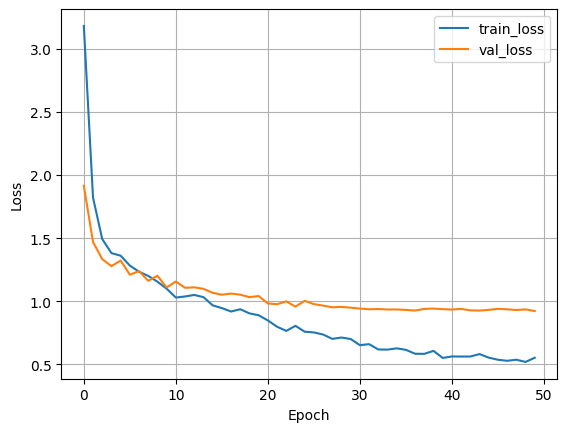

In [ ]:
model = Emformer_Classifier(input_dim=256).to('cuda:5')
print(f"Number of parameters: {count_params(model)}")

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40], gamma=0.5)


train_model(model, train_dataloader, val_dataloader, num_epochs=100, num_eval_epoch=1, 
            criterion=None, optimizer=optimizer, scheduler=scheduler, 
            save_dir = "/data/pitch_estimation/Emformer_MIR1k_bs64", gpu_number = 5)

plot_loss("/data/pitch_estimation/Emformer_MIR1k_bs64")

In [ ]:
min(result['val_loss'])

0.9576840457320214

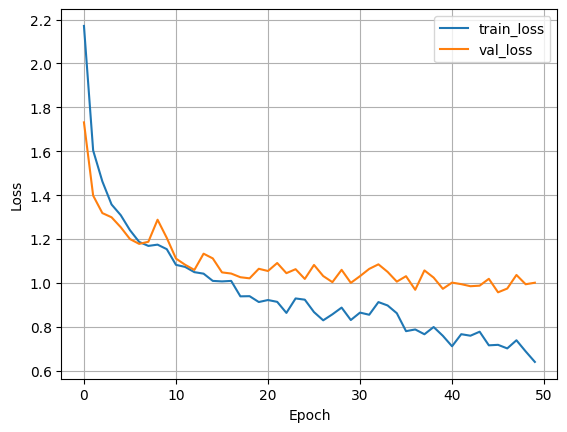